## Use content loss to create a super-resolution network

In [13]:
%matplotlib inline

import importlib
import sys
sys.path.insert(0, '../util')
import utils; importlib.reload(utils)
from utils import *

In [14]:
dpath = '/mnt/data/manish/data/'

In [15]:
arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:]

In [16]:
parms = {'verbose': 1, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [17]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)


In [18]:
# This model here is using the previously defined blocks to encode a low resolution image and 
# then upsample it to match the same image in high resolution.

inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [19]:
# shp = 
shp = outp.shape[1:]

preproc = lambda x: (x-imagenet_mean)[:,:,:,::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + imagenet_mean, 0, 255)


The method of training this network is almost exactly the same as training the pixels from our previous implementations. The idea here is we're going to feed two images to Vgg16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image. 

The key then is to train this other network to produce an image that minimizes the loss between the outputs of some convolutional layer in Vgg16 (which the paper refers to as "perceptual loss"). In doing so, we are able to train a network that can upsample an image and recreate the higher resolution details.

In [20]:
vgg_inp=Input(shp)
vgg = VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [21]:
# Since we only want to learn the "upsampling network", and are just using VGG to calculate the loss function, 
# we set the Vgg layers to not be trainable.
for l in vgg.layers: l.trainable=False

In [24]:
vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, Dimension(288) 0                                            
____________________________________________________________________________________________________
lambda_5 (Lambda)                (None, 288, 288, 3)   0           input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 288, 288, 64)  1792        lambda_5[0][0]                   
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 288, 288, 64)  36928       block1_conv1[0][0]               
___________________________________________________________________________________________

In [37]:
def get_outp(m, o): return m.get_layer('block{}_conv1'.format(o)).output


An important difference in training for super resolution is the loss function. We use what's known as a perceptual loss function (which is simply the content loss for some layer).

In [38]:
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in range(1,4)])

vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [39]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [40]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [41]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

Finally we compile this chain of models and we can pass it the original low resolution image as well as the high resolution to train on. We also define a zero vector as a target parameter, which is a necessary parameter when calling fit on a keras model.

In [42]:
m_sr.compile('adam', 'mse')
m_sr.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 72, 72, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 72, 72, 64)    15616       input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_12 (BatchNorm (None, 72, 72, 64)    256         convolution2d_13[0][0]           
____________________________________________________________________________________________________
activation_8 (Activation)        (None, 72, 72, 64)    0           batchnormalization_12[0][0]      
___________________________________________________________________________________________

In [ ]:
m_sr.fit([arr_lr, arr_hr], targ, 16, 2, **parms)

A Jupyter Widget

A Jupyter Widget

Epoch 1/2
19439/19439 [==============================] - 856s - loss: 22685.9402   



In [ ]:
K.get_value(m_sr.optimizer.lr)


In [ ]:
# We use learning rate annealing to get a better fit.
print(m_sr.optimizer.lr)
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, **parms)

In [46]:
# We are only interested in the trained part of the model, which does the actual upsampling.
top_model = Model(inp, outp)

In [47]:
p = top_model.predict(arr_lr[10:11])

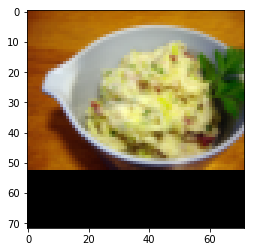

In [48]:
plt.imshow(arr_lr[10].astype('uint8'));

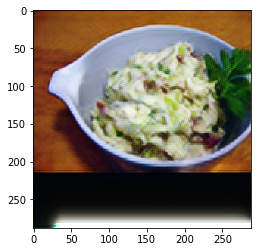

In [49]:
plt.imshow(p[0].astype('uint8'));

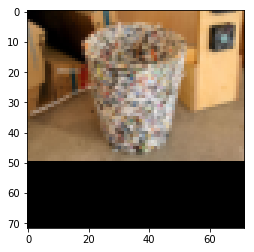

In [53]:
plt.imshow(arr_lr[1110].astype('uint8'));

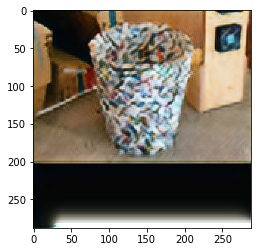

In [54]:
p = top_model.predict(arr_lr[1110:1111])
plt.imshow(p[0].astype('uint8'));

In [50]:
top_model.save_weights(dpath+'sr_final.h5')

In [55]:
top_model.load_weights(dpath+'sr_final.h5')

The important thing to take away here is that as opposed to our earlier approaches, this type of approach results in a model that can created the desired image and is a scalable implementation.
Note that we haven't used a test set here, so we don't know if the above result is due to over-fitting. As part of your homework, you should create a test set, and try to train a model that gets the best result you can on the test set.